<a href="https://colab.research.google.com/github/omdena/earthquake/blob/master/Q_learning_on_dummy_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-learning to find safe path

This notebook demonstrate a simple Q-learning approach to find a safe route to a destination. For now I am going to make use of dummy data.

I would like to thank those who have made awesome tutorials and resources (see references at the bottom).

## Installing Packages

In [0]:
%%capture
!pip install geopandas
!apt install libspatialindex-dev
!pip install rtree
!pip install osmnx

If you are running this notebook in google colab make sure you restart the runtime after successful installation of packages.

## Geo Data

In [0]:
import osmnx as ox
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt

Let's get a small map for analysis.

In [0]:
# a place in istanbul
place_name = "Kapali, Istanbul, Turkey"

In [0]:
# get the map data
graph = ox.graph_from_place(place_name)
# let's number integers for all the nodes in the graph
graph = nx.relabel.convert_node_labels_to_integers(graph)

In [235]:
type(graph)

networkx.classes.multidigraph.MultiDiGraph

Visualize how nodes and edges distributed over the area

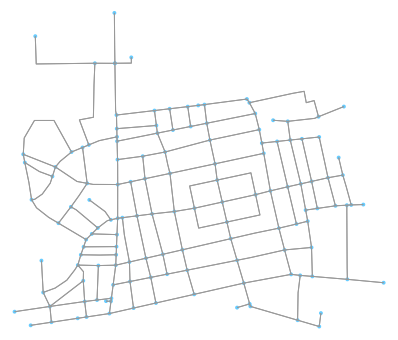

<Figure size 432x288 with 0 Axes>

In [236]:
fig, ax = ox.plot_graph(graph)
plt.tight_layout()

In [0]:
# get the bounding area
area = ox.gdf_from_place(place_name)

In [0]:
# get information of buildings
buildings = ox.footprints_from_place(place_name)

In [239]:
type(area), type(buildings)

(geopandas.geodataframe.GeoDataFrame, geopandas.geodataframe.GeoDataFrame)

In [0]:
# extract nodes and edges like a pandas dataframe
nodes_df, edges_df = ox.graph_to_gdfs(graph)

Let's analyze node data.

In [241]:
nodes_df.head()

,y,x,osmid,geometry
0,41.010094,28.969963,278005047,POINT (28.96996 41.01009)
1,41.010091,28.968678,2605667829,POINT (28.96868 41.01009)
2,41.009880,28.967444,2674464450,POINT (28.96744 41.00988)
3,41.009965,28.967458,2683365496,POINT (28.96746 41.00997)
4,41.009966,28.967413,2683365497,POINT (28.96741 41.00997)


In [0]:
# make a column having node number
nodes_df['node_no'] = np.arange(len(nodes_df))

In [243]:
nodes_df.head()

,y,x,osmid,geometry,node_no
0,41.010094,28.969963,278005047,POINT (28.96996 41.01009),0
1,41.010091,28.968678,2605667829,POINT (28.96868 41.01009),1
2,41.009880,28.967444,2674464450,POINT (28.96744 41.00988),2
3,41.009965,28.967458,2683365496,POINT (28.96746 41.00997),3
4,41.009966,28.967413,2683365497,POINT (28.96741 41.00997),4


Let's see how many nodes we have.

In [244]:
nodes_df.shape

(136, 5)

We have 136 nodes.

Time to analyze edge data.

In [245]:
edges_df.head()

,u,v,key,osmid,name,highway,oneway,length,geometry
0,0,25,0,303865763,Kalpakçılarbaşı Caddesi,pedestrian,False,28.087,"LINESTRING (28.96996 41.01009, 28.96995 41.010..."
1,1,6,0,261817324,Kalpakçilarbaşı Caddesi,pedestrian,False,37.116,"LINESTRING (28.96868 41.01009, 28.96911 41.01015)"
2,1,61,0,261817324,Kalpakçilarbaşı Caddesi,pedestrian,False,39.205,"LINESTRING (28.96868 41.01009, 28.96822 41.01001)"
3,1,57,0,262668172,NaN,pedestrian,False,16.654,"LINESTRING (28.96868 41.01009, 28.96873 41.00995)"
4,1,33,0,303865759,Kolancılar Sokak,pedestrian,False,18.339,"LINESTRING (28.96868 41.01009, 28.96862 41.01025)"


In [246]:
type(edges_df)

geopandas.geodataframe.GeoDataFrame

In [247]:
edges_df.shape

(414, 9)

We have 414 edges in the graph (including edges forming loops with 2 nodes, Eg: edge (0, 25) and edge (25,0) are present in the dataframe).

Now let's visualize the collected geo data

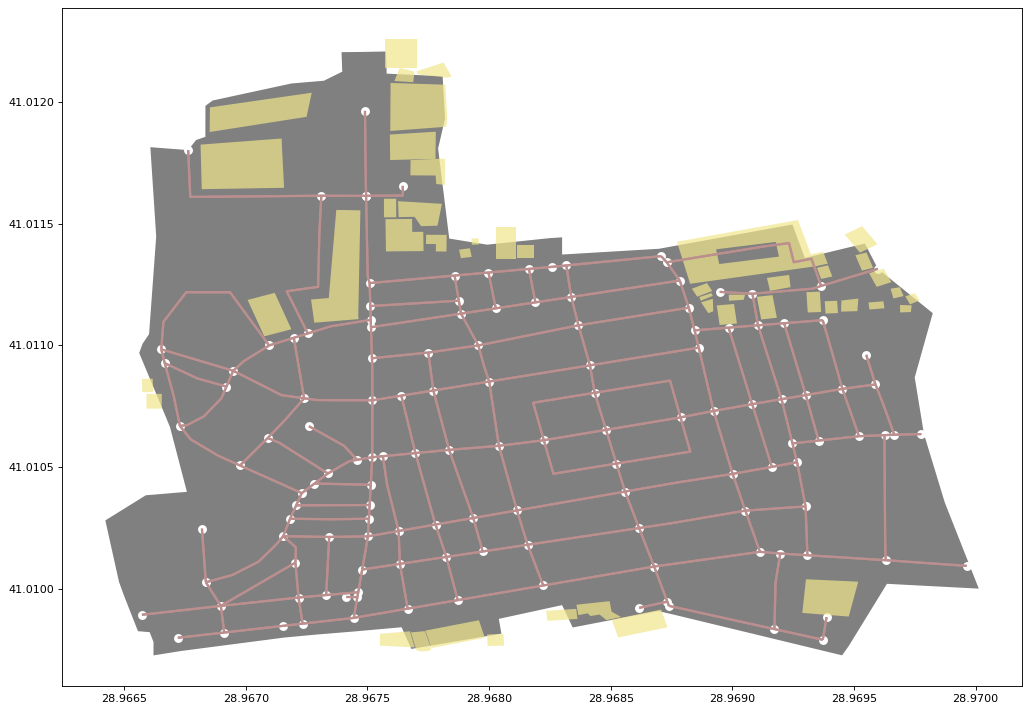

In [248]:
fig, ax = plt.subplots(figsize=(14, 9), dpi= 80)
area.plot(ax=ax, facecolor='gray')
edges_df.plot(ax=ax, linewidth=2, edgecolor='#BC8F8F')
nodes_df.plot(ax=ax, linewidth=2, facecolor='white')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)
plt.tight_layout()

## Heat map

In this approach I need to classify all the edges based on the risk of passing through the edges, which is based on the heat map. But we are still working on the heat map I will be using fake classified
 data for that.

I am rating each edges such that 0 means less risky and 5 means very much risky.

In [0]:
# array of length = number of edges
danger = np.zeros(len(edges_df))

In [0]:
def rate(rate, frequency, data):

    '''
    function to manipulate data array.

    rate : rate of risk Eg.(0-5)
    frequency : how many time the element in the array to be manipulated.
    data : numpy array holding the data
    '''
    for i in range(frequency):
        idx = np.random.randint(0, data.shape[0])
        data[idx] = rate

    return data

In [367]:
# manipulate the array of zeros
danger = rate(1, 128, danger)
danger = rate(2, 64, danger)
danger = rate(3, 32, danger)
danger = rate(4, 16, danger)
danger = rate(5, 16, danger)
danger

array([0., 2., 1., 1., 0., 2., 0., 2., 0., 2., 2., 3., 1., 0., 0., 2., 1.,
       1., 0., 2., 2., 0., 0., 1., 2., 0., 5., 1., 1., 2., 3., 0., 2., 5.,
       1., 2., 1., 2., 2., 2., 0., 5., 2., 4., 2., 0., 0., 2., 1., 3., 1.,
       0., 3., 0., 0., 3., 0., 1., 0., 1., 1., 1., 0., 2., 2., 0., 3., 0.,
       0., 3., 0., 3., 0., 5., 0., 0., 0., 1., 5., 5., 2., 0., 2., 0., 2.,
       3., 3., 0., 4., 1., 0., 3., 0., 0., 0., 1., 2., 1., 4., 3., 1., 0.,
       2., 2., 2., 1., 0., 5., 3., 1., 0., 1., 0., 1., 0., 2., 0., 0., 5.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 3., 2., 0., 3., 1., 2.,
       1., 0., 1., 0., 0., 0., 1., 1., 2., 0., 1., 3., 0., 5., 2., 2., 1.,
       1., 1., 1., 2., 2., 5., 1., 0., 1., 5., 0., 4., 4., 3., 1., 2., 1.,
       2., 2., 1., 1., 1., 1., 1., 5., 3., 0., 1., 1., 2., 1., 1., 1., 2.,
       0., 2., 0., 1., 3., 1., 2., 2., 0., 1., 0., 1., 1., 0., 2., 4., 2.,
       5., 1., 5., 2., 3., 0., 0., 0., 0., 1., 1., 0., 2., 2., 1., 2., 3.,
       1., 2., 1., 4., 2.

In [368]:
# write this information to the node dataframe
edges_df['risk_rate'] = danger
edges_df.head()

,u,v,key,osmid,name,highway,oneway,length,geometry,risk_rate
0,0,25,0,303865763,Kalpakçılarbaşı Caddesi,pedestrian,False,28.087,"LINESTRING (28.96996 41.01009, 28.96995 41.010...",0.0
1,1,6,0,261817324,Kalpakçilarbaşı Caddesi,pedestrian,False,37.116,"LINESTRING (28.96868 41.01009, 28.96911 41.01015)",2.0
2,1,61,0,261817324,Kalpakçilarbaşı Caddesi,pedestrian,False,39.205,"LINESTRING (28.96868 41.01009, 28.96822 41.01001)",1.0
3,1,57,0,262668172,NaN,pedestrian,False,16.654,"LINESTRING (28.96868 41.01009, 28.96873 41.00995)",1.0
4,1,33,0,303865759,Kolancılar Sokak,pedestrian,False,18.339,"LINESTRING (28.96868 41.01009, 28.96862 41.01025)",0.0


Now let's visualize the nodes based on the risk rate.

In [0]:
import matplotlib.colors as colors

cmap = colors.ListedColormap(['green','pink', 'blue', 'violet','orange', 'red'])
boundaries = [0, 1, 2, 3, 4, 5, 6]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

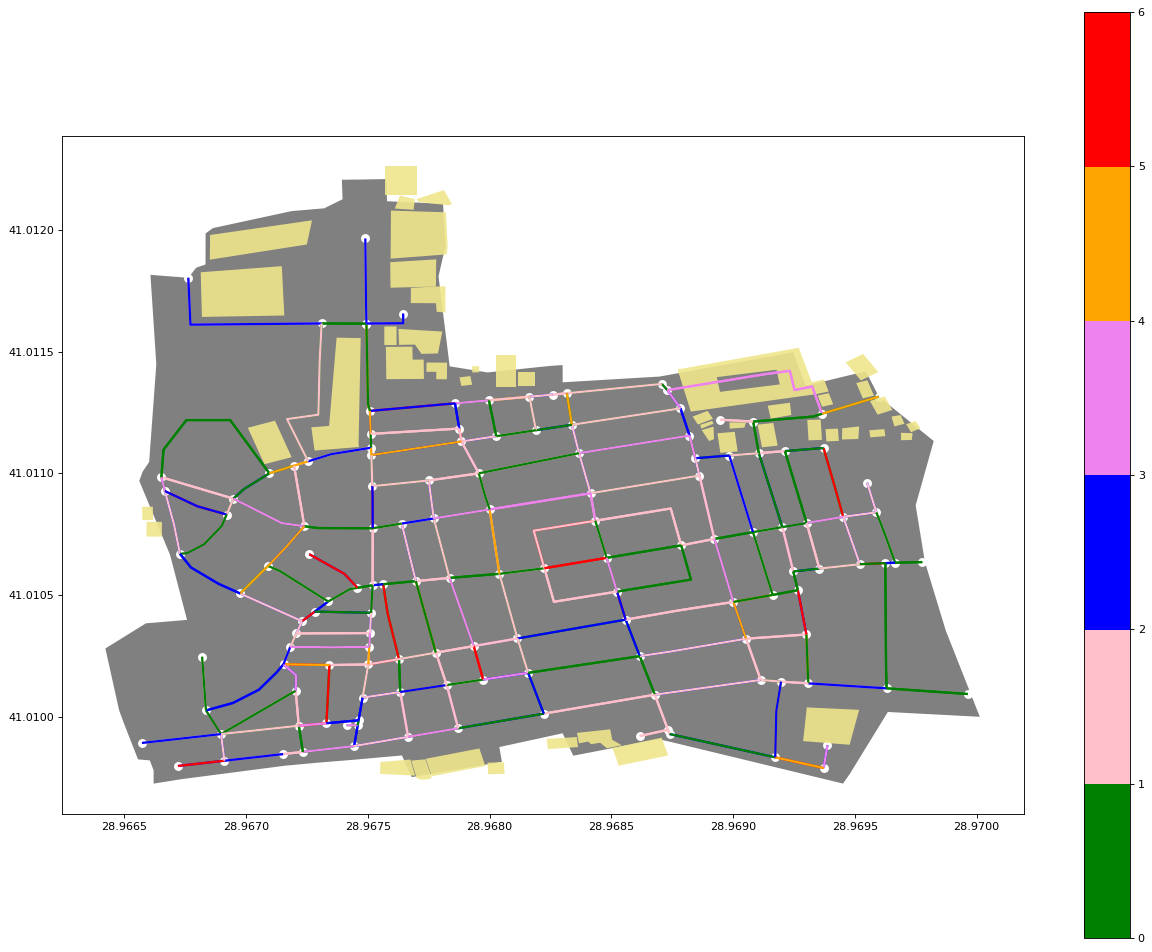

In [370]:
fig, ax = plt.subplots(figsize=(16, 12), dpi= 80)
area.plot(ax=ax, facecolor='gray')
edges_df.plot(ax=ax, linewidth=2, column='risk_rate', cmap=cmap, norm=norm)
nodes_df.plot(ax=ax, linewidth=2, facecolor='white')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.9)
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm))
plt.tight_layout()

**Note:** Eventhough we randomly generated risk rate for all the edges, edges will override since we are interested in undirected grphs.
Eg: The risk rate assigned to edge (0, 25) will be overriden by the risk rate of edge (25, 0).

## Graph for Analysis

In this section I will convert the nodes and edges in the geo data to a networkx graph.

In [0]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
%matplotlib inline

In [372]:
edges = [(edges_df.u[i], edges_df.v[i], {'risk_rate': int(edges_df.risk_rate[i]), 'length':float(edges_df.length[i])})for i in range(edges_df.shape[0])]
edges[:10]

[(0, 25, {'length': 0.00033412041661628106, 'risk_rate': 0}),
 (1, 6, {'length': 0.000439200819671544, 'risk_rate': 2}),
 (1, 61, {'length': 0.00046231039356920686, 'risk_rate': 1}),
 (1, 57, {'length': 0.0001539208238022928, 'risk_rate': 1}),
 (1, 33, {'length': 0.00016984251529150247, 'risk_rate': 0}),
 (2, 69, {'length': 0.00022481763720858571, 'risk_rate': 2}),
 (2, 35, {'length': 0.00021174182392674998, 'risk_rate': 0}),
 (2, 3, {'length': 8.654045297058885e-05, 'risk_rate': 2}),
 (3, 4, {'length': 4.5605372490525595e-05, 'risk_rate': 0}),
 (3, 2, {'length': 8.654045297058885e-05, 'risk_rate': 2})]

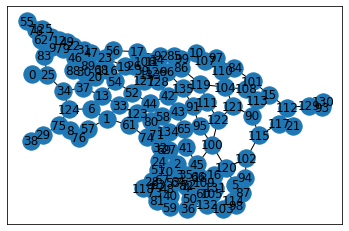

In [373]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
plt.show()

## Q-Learning

Let's find the **safe route from node 0 to 120**.

So initialize Reward and Q-matrix.

In [374]:
# reward matrix with all elements initialized to zero and shape (no. of nodes X no. of nodes)
R = np.matrix(np.zeros(shape=(nodes_df.shape[0], nodes_df.shape[0])))
R

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

**Reward Logic**
- Give a small negative reward based on the path taken and proportional to the risk rate associated with the path.
- Give a high positive reward to all actions arriving destination node. (here it is node number 120)

In [0]:
# first reward logic
for node in G.nodes:
    for x in G[node]:
        R[node, x] = -2 * int(G[node][x]['risk_rate'])
        R[x, node] = -2 * int(G[x][node]['risk_rate'])

In [376]:
# set high reward to actions arriving at node 120
for x in G[120]:
    R[x, 120] = 100

pd.DataFrame(R)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-4.0,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.0,0.0,0.0,0.0
132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.0,0.0,0.0,0.0,0.0
133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Q-Matrix initialization Logic**
- Impossible actions are set -100
- Rest are initilized to 0

In [377]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505
Q = np.matrix(np.zeros(shape=(nodes_df.shape[0], nodes_df.shape[0])))
Q-=100
for node in G.nodes:
    for x in G[node]:
        Q[node, x] = 0
        Q[x, node] = 0
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
3,-100.0,-100.0,0.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0
132,-100.0,-100.0,-100.0,-100.0,-

In [0]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505

def get_next_node(start, er):
    '''
    Define a function which takes a starting node and returns the next node.
    It also accepts an exploration rate for random exploration.
    Otherwise, it chooses action according to the highest Q value of the possible actions.
    '''
    random_value = random.uniform(0,1)

    if random_value<er:
        sample = list(G[start])
    else:
        sample = np.where(Q[start,] == np.max(Q[start,]))[1]

    next_node = int(np.random.choice(sample, 1))

    return next_node

In [0]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505

def updateQ(node1, node2, lr, discount):
    '''
    Function for updating Q-value of the action taken.
    '''
    max_index = np.where(Q[node2,] == np.max(Q[node2,]))[1]

    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    
    max_value = Q[node2, max_index]
    Q[node1, node2] = int((1-lr)*Q[node1, node2] + lr*(R[node1, node2] + discount*max_value))


In [0]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505

def learn(er, lr, discount):
    '''
    Function to integrate all the steps in Q-learning for 100000 iteration.
    '''
    for i in range(100000):
        start = np.random.randint(0,nodes_df.shape[0])
        next_node = get_next_node(start, er)
        updateQ(start, next_node, lr, discount)
    
    print('Done..!')


In [381]:
learn(0.5, 0.8, 0.8)

Done..!


In [382]:
# updated Q-table
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135
0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,9.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,27.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,39.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2,-100.0,-100.0,-100.0,30.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,25.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
3,-100.0,-100.0,42.0,-100.0,16.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,-100.0,-100.0,-100.0,28.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,274.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,159.0,-100.0,-100.0,-100.0
132,-100.0,-100.0,-100

In [0]:
# ref: https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505

def safe_path(begin, end):
    '''
    function returning node sequence(path)
    begin: starting node
    end: ending node
    '''
    path = [begin]
    next_node = np.argmax(Q[begin,])
    while next_node != end:
        next_node = np.argmax(Q[next_node,])
        path.append(next_node)
    
    return path

In [384]:
# Lets see the nodes in the safe path
path = safe_path(0,120)
path

[0, 34, 37, 13, 33, 123, 44, 42, 43, 65, 95, 100, 120]

In [0]:
def show_path(path):
    '''
    helper function for visualization
    '''
    x_line = []
    y_line = []
    for i in path:
        x, y = float(nodes_df[nodes_df.node_no == i]['x']), float(nodes_df[nodes_df.node_no == i]['y'])
        x_line.append(x)
        y_line.append(y)
    return x_line, y_line

In [0]:
# get x, y values of path
x_path, y_path = show_path(path)

Let's see our map with 'From' and 'To' locations.

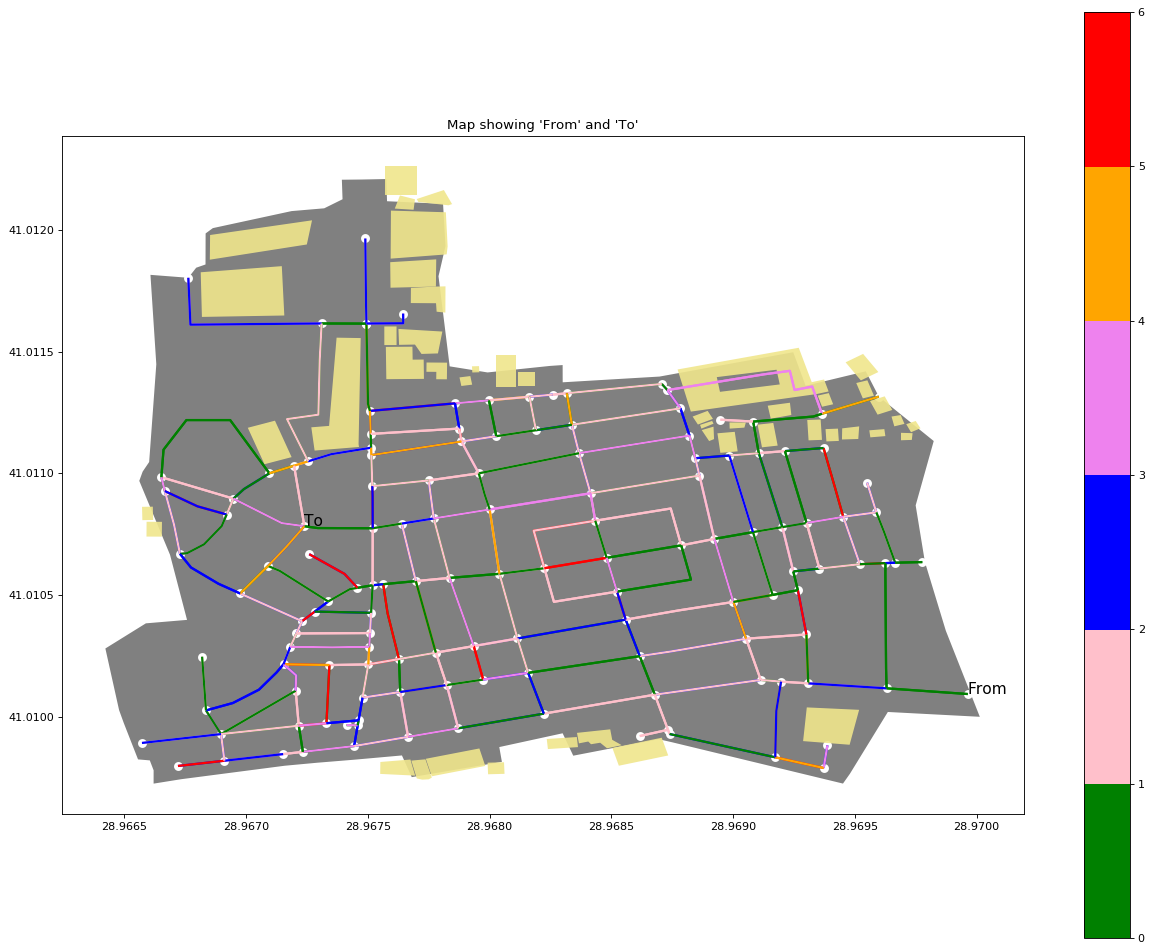

In [387]:
fig, ax = plt.subplots(figsize=(16, 12), dpi= 80)
area.plot(ax=ax, facecolor='gray')
edges_df.plot(ax=ax, linewidth=2, column='risk_rate', cmap=cmap, norm=norm)
nodes_df.plot(ax=ax, linewidth=2, facecolor='white')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.9)
plt.title('Map showing \'From\' and \'To\'')
plt.text(x_path[0], y_path[0], 'From', color='black', fontsize=14)
plt.text(x_path[-1], y_path[-1], 'To', color='black', fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm))
plt.tight_layout()

Now let's visualize the path..

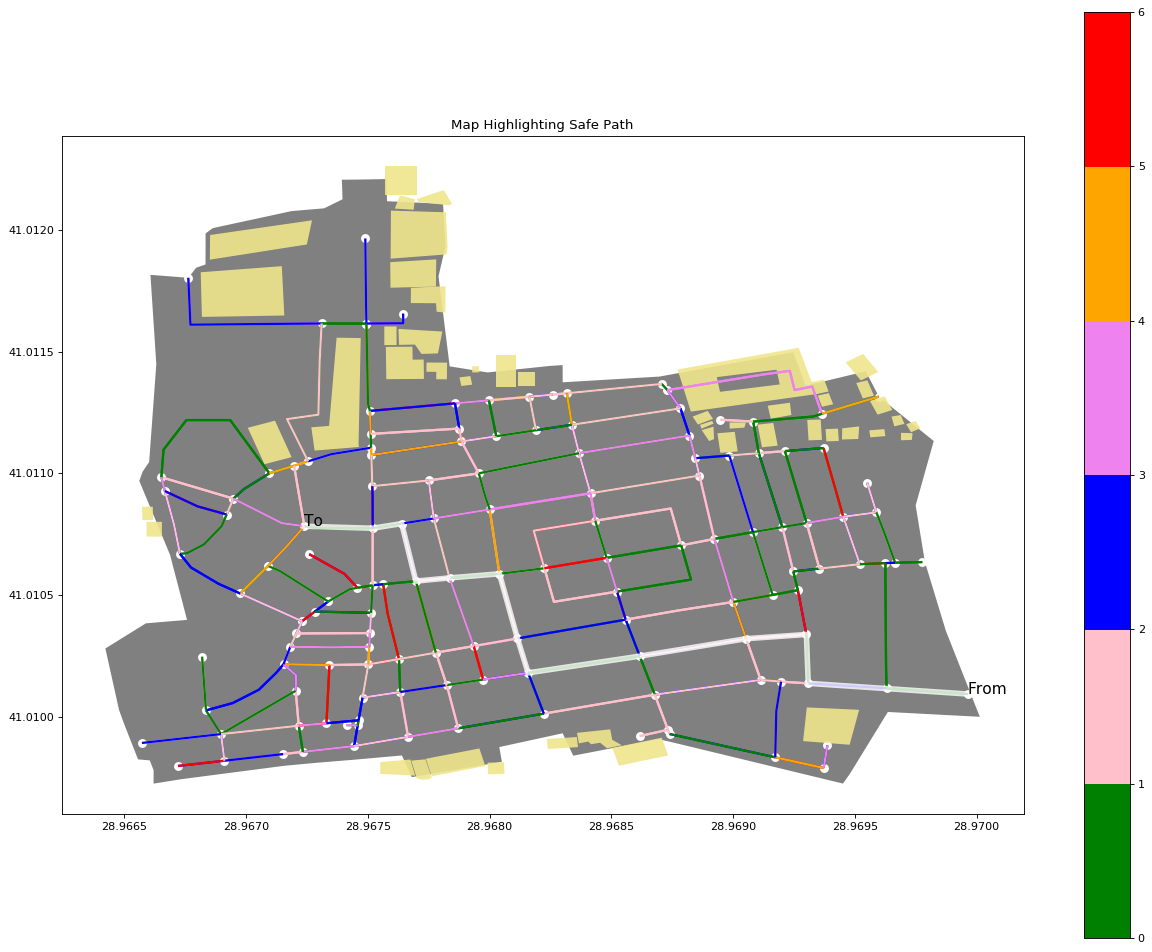

In [388]:
fig, ax = plt.subplots(figsize=(16, 12), dpi= 80)
area.plot(ax=ax, facecolor='gray')
nodes_df.plot(ax=ax, linewidth=2, facecolor='white')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.9)
plt.title('Map Highlighting Safe Path')
plt.plot(x_path, y_path, color='white', linewidth=5, alpha=0.8)
edges_df.plot(ax=ax, linewidth=2, column='risk_rate', cmap=cmap, norm=norm)
plt.text(x_path[0], y_path[0], 'From', color='black', fontsize=14)
plt.text(x_path[-1], y_path[-1], 'To', color='black', fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm))
plt.tight_layout()

Now let's do the visualization of the **shortest** path so that we can compare it with the **safe path**.

In [389]:
# nodes passing through the shortest path
short_path = nx.shortest_path(G,0,120,weight='length')
short_path

[0, 25, 34, 124, 6, 1, 33, 52, 127, 133, 128, 42, 43, 65, 95, 100, 120]

In [0]:
# get x, y values of shortest path
short_x, short_y = show_path(short_path)

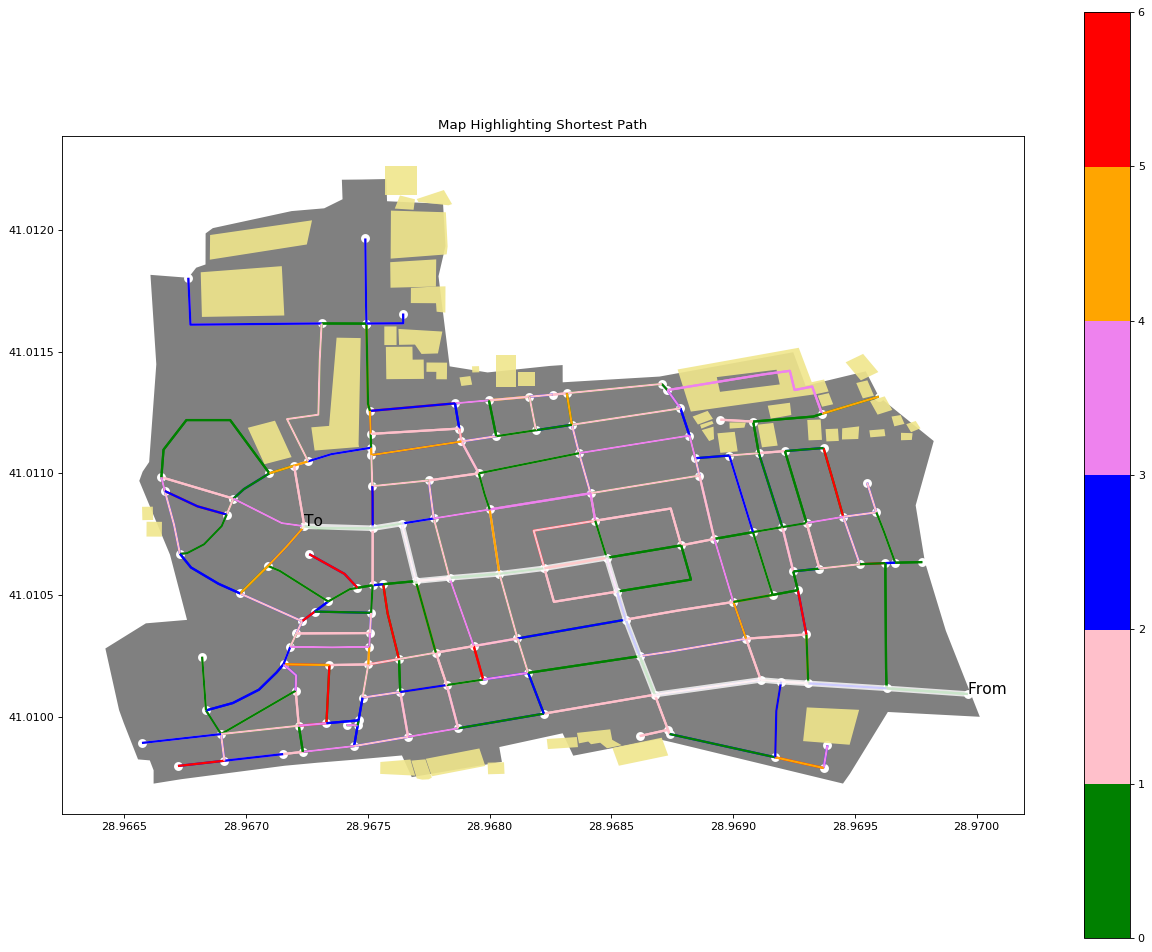

In [391]:
fig, ax = plt.subplots(figsize=(16, 12), dpi= 80)
area.plot(ax=ax, facecolor='gray')
nodes_df.plot(ax=ax, linewidth=2, facecolor='white')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.9)
plt.title('Map Highlighting Shortest Path')
plt.plot(short_x, short_y, color='white', linewidth=5, alpha=0.8)
edges_df.plot(ax=ax, linewidth=2, column='risk_rate', cmap=cmap, norm=norm)
plt.text(x_path[0], y_path[0], 'From', color='black', fontsize=14)
plt.text(x_path[-1], y_path[-1], 'To', color='black', fontsize=14)
plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm))
plt.tight_layout()

# References

- https://automating-gis-processes.github.io/CSC18/lessons/L1/Intro-Python-GIS.html
- https://towardsdatascience.com/finding-shortest-path-using-q-learning-algorithm-1c1f39e89505
- https://matplotlib.org/tutorials/index.html
- https://towardsdatascience.com/simple-example-of-2d-density-plots-in-python-83b83b934f67
- https://networkx.github.io